# Notebook 3 — Análisis de frecuencias de la señal EEG  
**Canal O1 (Emotiv EPOC+)**

**Materias relacionadas:**  
*Algoritmos Computacionales, Morfofuncional II, Matemáticas Avanzadas de la Física, Electrofisiología, Instrumentación Biomédica, Temas Selectos en Biomatemáticas y Temas Selectos en Biofísica.*

**Antecedentes:**  
Notebook 1 — Fisiología básica del EEG y preparación del entorno de Python.  
Notebook 2 — **Filtrado digital y análisis temporal de la señal EEG.**


### Objetivos  
- Comprender los fundamentos matemáticos del **análisis espectral** de señales biológicas.  
- Aplicar la **Transformada de Fourier** para estudiar la actividad eléctrica cerebral en distintas bandas de frecuencia.  
- Cuantificar el **bloqueo alfa** entre las condiciones de ojos abiertos (OA) y ojos cerrados (OC).  

Este cuaderno representa el paso natural tras el filtrado: se abandona el dominio temporal para construir una descripción **frecuencial cuantitativa** del EEG en el canal O1, permitiendo la comparación de potencias absolutas y relativas entre condiciones experimentales.


In [1]:
# 3.0 — Configuración general y parámetros experimentales

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# --- Estilo de figuras ---
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.grid"] = True

# --- Parámetros de adquisición ---
fm = 128              # Frecuencia de muestreo (Hz)
canal = "O1"           # Canal de análisis
ti_OA, tf_OA = 105.0, 120.0    # Ojos abiertos (s)
ti_OC, tf_OC = 120.0, 135.0    # Ojos cerrados (s)

# --- Filtro Butterworth (2–45 Hz) ---
f_low, f_high = 2.0, 45.0
orden = 4

# --- Bandas fisiológicas (Hz) ---
bandas = {
   "δ (0.5–4)" : (0.5, 4.0),
   "θ (4–8)"   : (4.0, 8.0),
   "α (8–13)"  : (8.0, 13.0),
   "β (13–30)" : (13.0, 30.0),
   "γ (30–45)" : (30.0, 45.0),
}

# --- Ruta de datos EEG ---
ruta_csv = "/Users/yann/Documents/Tesis/Datos/EEG/H24_OC_OA.csv"


## 3.1 Fundamentos biomatemáticos del análisis de frecuencias

El análisis de frecuencias constituye la transición del dominio temporal al dominio frecuencial.  
En el contexto del EEG, permite observar cómo la potencia eléctrica del cerebro se distribuye en distintas escalas de frecuencia,  
vinculadas a procesos neuronales específicos (Nunez & Srinivasan, 2006; Schomer & Lopes da Silva, 2018).

Mientras el dominio temporal describe **cuándo** ocurre un evento eléctrico,  
el dominio frecuencial permite estudiar **qué ritmos** lo componen y **con qué intensidad**.  
En este sentido, el análisis espectral es una herramienta biomatemática que traduce un fenómeno fisiológico complejo  
en una representación cuantitativa reproducible.

La sección se divide en cinco partes:  
1. Naturaleza de la señal EEG y su significado fisiológico.  
2. Modelado matemático de oscilaciones corticales.  
3. Definición y propiedades de la Transformada Discreta de Fourier (DFT).  
4. Concepto de densidad espectral de potencia (PSD).  
5. Estimación robusta mediante el método de Welch.

El objetivo es construir el marco teórico que sustenta el análisis espectral aplicado más adelante en el canal O1.

### 3.1.1 Señal EEG: del tiempo a la frecuencia

La señal electroencefalográfica (EEG) refleja la suma de potenciales eléctricos generados por poblaciones neuronales corticales.  
Matemáticamente puede considerarse una función $x(t)$ continua en el tiempo, cuya estructura contiene información sobre ritmos fisiológicos (Teplan, 2002).

El registro temporal del EEG muestra oscilaciones de amplitud variable, moduladas por el estado sensorial y cognitivo del sujeto.  
Sin embargo, la simple observación temporal no revela **qué frecuencias contribuyen** a esas oscilaciones.  
Por ello, el análisis espectral resulta indispensable: permite descomponer la señal en componentes armónicas  
y cuantificar la potencia de cada banda de frecuencia (Nunez & Srinivasan, 2006).

Las bandas fisiológicas se agrupan tradicionalmente según el rango de frecuencia dominante y su correlato funcional (Schomer & Lopes da Silva, 2018):

| Banda | Rango (Hz) | Asociación fisiológica principal |
|:------|:-----------:|:--------------------------------|
| δ | 0.5–4 | Sueño profundo, sincronización cortical lenta |
| θ | 4–8 | Somnolencia, procesos límbicos |
| α | 8–13 | Reposo visual, atención interna |
| β | 13–30 | Actividad motora y sensorial |
| γ | 30–45 | Integración perceptual y cognitiva |

En la práctica, la señal EEG no es estrictamente estacionaria: sus propiedades estadísticas cambian en el tiempo.  
Por ello, el análisis se realiza bajo el supuesto de **estacionariedad local**,  
considerando ventanas de algunos segundos en las que las variaciones son lo suficientemente pequeñas  
para aplicar modelos lineales y transformadas de Fourier de forma válida.


### 3.1.2 Modelado matemático y fisiología

El análisis espectral parte del supuesto de que una señal puede describirse como la superposición de componentes oscilatorias elementales.  
En su forma más simple:

$$
x(t) = \sum_{k=1}^{N} A_k \cos(2\pi f_k t + \phi_k)
$$

donde $A_k$ es la amplitud, $f_k$ la frecuencia y $\phi_k$ la fase de cada componente (Nunez & Srinivasan, 2006).  
Este modelo no busca imitar la fisiología neuronal exacta, sino proporcionar un **lenguaje cuantitativo**  
para representar fenómenos eléctricos complejos mediante parámetros medibles (He, 2019).

El evento fisiológico **no se adapta al modelo**, sino que el modelo ofrece un **marco para describirlo y compararlo**.  
Las matemáticas actúan como mediadoras entre observación y teoría:  
permiten identificar regularidades, establecer relaciones y comunicar resultados de forma reproducible (Cohen, 2014).

En neurociencia, este tipo de modelado es fundamental porque posibilita estudiar la dinámica cortical  
a partir de datos eléctricos, sin perder el vínculo con su interpretación fisiológica.


### 3.1.3 Transformada discreta de Fourier (DFT), FFT y simetría del espectro

La **Transformada Discreta de Fourier (DFT)** es la herramienta matemática que traduce una señal discreta en su representación en frecuencia.  
Permite descomponer la señal $x[n]$ en un conjunto de senoidales complejas, cada una asociada a una frecuencia específica (Oppenheim & Schafer, 2010):

$$
X[k] = \sum_{n=0}^{N-1} x[n]\,e^{-j 2\pi kn/N}
$$

Cada coeficiente $X[k]$ representa la contribución de la frecuencia discreta

$$
f_k = \frac{k\,f_m}{N}
$$

donde $f_m$ es la frecuencia de muestreo y $N$ el número total de muestras.  
El módulo $|X[k]|^2$ mide la **energía relativa** de cada componente en el espectro (Proakis & Manolakis, 2006).  
De este modo, el dominio frecuencial permite observar los ritmos dominantes de una señal EEG y su distribución energética.

En el caso de señales fisiológicas, esta descomposición revela la coexistencia de oscilaciones lentas (δ, θ) y rápidas (β, γ),  
así como el comportamiento característico de la banda α en regiones occipitales (Nunez & Srinivasan, 2006).

Para visualizar este principio, se analiza una señal sintética compuesta por dos frecuencias: 10 Hz y 20 Hz.


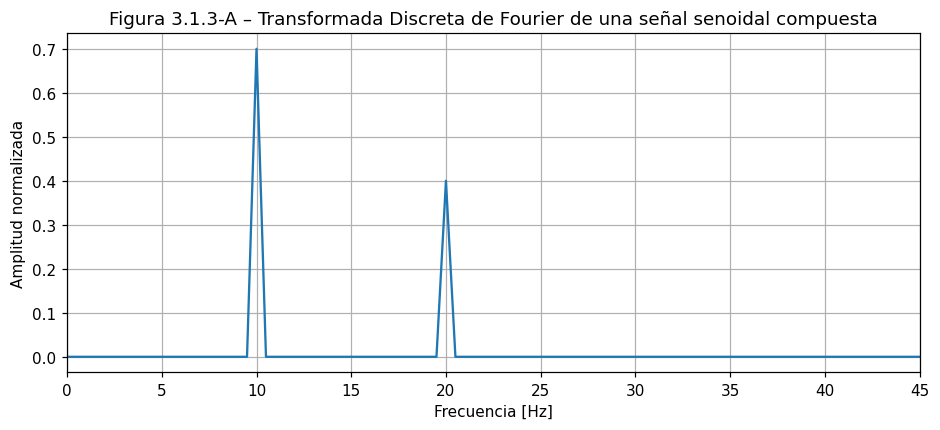

In [2]:
# Ejemplo 3.1.3-A — Transformada Discreta de Fourier (DFT) de una señal compuesta

import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la señal
fm_demo = 128          # Frecuencia de muestreo [Hz]
t = np.arange(0, 2, 1/fm_demo)  # 2 segundos de duración

# Señal compuesta: suma de senoidales de 10 Hz y 20 Hz
x = 0.7*np.sin(2*np.pi*10*t) + 0.4*np.sin(2*np.pi*20*t)

# Cálculo de la FFT y sus frecuencias asociadas
N = len(x)
X = np.fft.fft(x)
freqs = np.fft.fftfreq(N, d=1/fm_demo)

# Magnitud normalizada (se considera solo el semiespectro positivo)
mag = 2*np.abs(X[:N//2]) / N

# Visualización
plt.figure(figsize=(10,4))
plt.plot(freqs[:N//2], mag, color='tab:blue')
plt.title('Figura 3.1.3-A – Transformada Discreta de Fourier de una señal senoidal compuesta')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Amplitud normalizada')
plt.xlim(0, 45)
plt.grid(True)
plt.show()


La **Figura 3.1.3-A** muestra dos picos en 10 Hz y 20 Hz, correspondientes a las frecuencias constituyentes de la señal.  
La energía del dominio temporal se concentra en valores discretos de frecuencia,  
lo que demuestra la relación directa entre la Transformada de Fourier y la descomposición armónica descrita en la teoría (Oppenheim & Schafer, 2010; Proakis & Manolakis, 2006).


### 3.1.4 Densidad espectral de potencia (PSD)

La **densidad espectral de potencia (PSD)** describe cómo la energía de una señal se distribuye en función de la frecuencia.  
Mientras que la Transformada de Fourier muestra qué frecuencias están presentes,  
la PSD cuantifica **cuánta potencia** aporta cada una de ellas (Papoulis, 1984; Oppenheim & Schafer, 2010).

Formalmente, la PSD de una señal $x(t)$ se define como:

$$
S_{xx}(f) = \lim_{T \to \infty} \frac{1}{T}\,|X_T(f)|^2
$$

donde $X_T(f)$ es la transformada de Fourier de la señal truncada a una duración $T$.  
En la práctica, esta estimación se realiza sobre intervalos finitos, asumiendo **estacionariedad local**.  
Las unidades de la PSD son $V^2/Hz$,  
lo que representa la potencia media (en voltaje cuadrado) por unidad de ancho de banda (Smith, 1997).

El área bajo la curva de la PSD corresponde a la potencia total de la señal:

$$
P_\text{total} = \int_0^{f_m/2} S_{xx}(f)\,df
$$

Esta relación vincula de manera directa el dominio temporal con el dominio frecuencial.  
En neurofisiología, el valor de la PSD en cada banda (δ, θ, α, β, γ) permite interpretar estados corticales específicos (Nunez & Srinivasan, 2006).


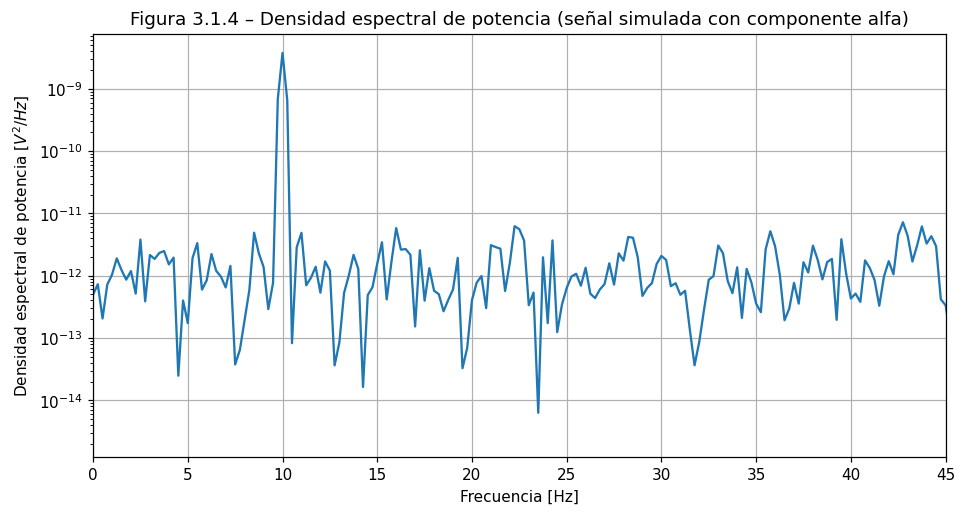

In [3]:
# Ejemplo 3.1.4 – Cálculo y visualización de la densidad espectral de potencia (PSD)

from scipy import signal

# Generar señal simulada con una componente alfa dominante (10 Hz)
np.random.seed(42)
fm_demo = 128
t = np.arange(0, 5, 1/fm_demo)
x = 50e-6 * np.sin(2*np.pi*10*t) + 10e-6 * np.random.randn(len(t))  # 10 Hz + ruido blanco

# Estimar PSD con el método de Welch
f, Pxx = signal.welch(x, fs=fm_demo, window='hamming', nperseg=512, noverlap=256, scaling='density')

# Visualización
plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx, color='tab:blue')
plt.title('Figura 3.1.4 – Densidad espectral de potencia (señal simulada con componente alfa)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia [$V^2/Hz$]')
plt.xlim(0, 45)
plt.grid(True)
plt.show()


La **Figura 3.1.4** muestra la distribución espectral de la potencia en una señal con una componente dominante a 10 Hz.  
El pico principal en esta frecuencia corresponde al ritmo **α**, característico del reposo visual y de la sincronización occipital (Schomer & Lopes da Silva, 2018).  

La PSD permite, por tanto, traducir el comportamiento oscilatorio del EEG en una descripción cuantitativa,  
donde cada punto del espectro indica la potencia promedio asociada a una frecuencia específica.  
Este enfoque constituye la base de los análisis comparativos que se aplicarán más adelante a los datos experimentales del canal O1.


### 3.1.5 Del periodograma al método de Welch

El **periodograma** es el estimador más sencillo de la densidad espectral de potencia (PSD).  
Se obtiene a partir del cuadrado de la magnitud de la Transformada de Fourier y su normalización por la longitud de la señal (Papoulis, 1984; Kay, 1988):

$$
\hat{S}_{xx}(f) = \frac{1}{T}\,|X_T(f)|^2
$$

Aunque conceptualmente simple, el periodograma presenta **alta varianza**:  
pequeñas variaciones en la señal producen fluctuaciones considerables en el espectro estimado.  
Además, el resultado depende del tamaño de la ventana y de su posición temporal,  
lo que dificulta la reproducibilidad (Proakis & Manolakis, 2006).

Para reducir estos problemas, Welch (1967) propuso un método que mejora la estabilidad de la estimación.  
Consiste en dividir la señal en segmentos solapados, aplicar una ventana (por ejemplo, de Hamming)  
y promediar los periodogramas resultantes.  
Este promediado disminuye la varianza a costa de una leve pérdida de resolución en frecuencia.  
El método de Welch se ha convertido en el estándar para el análisis de señales EEG y biomédicas,  
ya que asume estacionariedad local y proporciona espectros más suaves y comparables (Hsu et al., 2021; Bronzino & Peterson, 2020).


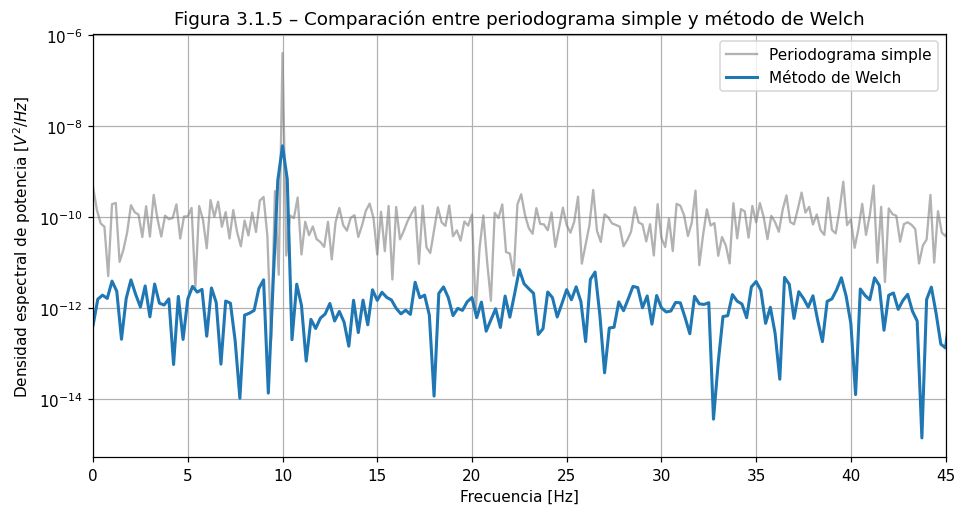

In [4]:
# Ejemplo 3.1.5 – Comparación entre el periodograma simple y el método de Welch

# --- Señal simulada (mismo ejemplo anterior) ---
fm_demo = 128
t = np.arange(0, 5, 1/fm_demo)
x = 50e-6 * np.sin(2*np.pi*10*t) + 10e-6 * np.random.randn(len(t))

# --- Periodograma directo ---
N = len(x)
freqs = np.fft.fftfreq(N, d=1/fm_demo)
P_per = (np.abs(np.fft.fft(x))**2) / N

# --- Welch (ventana Hamming, 50 % solape) ---
f_welch, P_welch = signal.welch(x, fs=fm_demo, window='hamming', nperseg=512,
                                noverlap=256, scaling='density')

# --- Visualización comparativa ---
plt.figure(figsize=(10,5))
plt.semilogy(freqs[:N//2], P_per[:N//2], color='tab:gray', alpha=0.6, label='Periodograma simple')
plt.semilogy(f_welch, P_welch, color='tab:blue', linewidth=2, label='Método de Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia [$V^2/Hz$]')
plt.title('Figura 3.1.5 – Comparación entre periodograma simple y método de Welch')
plt.legend()
plt.xlim(0, 45)
plt.grid(True)
plt.show()


La **Figura 3.1.5** compara las estimaciones de la densidad espectral de potencia obtenidas mediante el **periodograma simple** (gris) y el **método de Welch** (azul).  
El periodograma directo refleja el cuadrado de la FFT de una sola ventana y, por ello, exhibe **alta resolución en frecuencia pero gran varianza**: pequeñas fluctuaciones en la señal generan picos y valles irregulares a lo largo del espectro.  
El método de Welch, en cambio, **promedia múltiples periodogramas solapados y ventaneados**, reduciendo así la varianza y produciendo una representación más estable de la distribución de potencia (Welch, 1967; Hsu et al., 2021).

El efecto visual de este promediado es el **suavizado del espectro**:  la curva azul parece “barrer” el ruido de fondo del periodograma gris,  manteniendo los picos que aparecen de forma consistente en las distintas ventanas.  
Esto explica por qué el pico correspondiente a la banda **α (≈10 Hz)** se conserva,  
mientras que las fluctuaciones aleatorias en β y γ desaparecen.

En términos fisiológicos, la estimación de Welch refleja mejor las **componentes persistentes** de la señal EEG,  
aquellas que se repiten en el tiempo y representan actividad neuronal sostenida.  
Así, aunque la resolución en frecuencia es ligeramente menor, la estabilidad estadística del resultado es mucho mayor,  
lo que permite comparar condiciones experimentales o calcular potencias por bandas con confianza.

Esta diferencia ilustra la ventaja del método de Welch para señales biológicas,  
donde la potencia debe estimarse dentro de intervalos de **estacionariedad local** y con mínima influencia del ruido.  
El resultado es una descripción más reproducible del contenido frecuencial promedio,  
apta para los análisis cuantitativos que se aplicarán en el canal O1 en la sección 3.2.


#### Nota metodológica — Selección de parámetros en el método de Welch

La estabilidad y resolución del método de Welch dependen de tres parámetros principales:  
1. **Longitud del segmento (`nperseg`)**  
2. **Porcentaje de solape (`noverlap`)**  
3. **Tipo de ventana**

Estos valores determinan el equilibrio entre resolución en frecuencia, varianza espectral y grado de suavizado del resultado.

- **Longitud del segmento (`nperseg`)**  
  En registros EEG con frecuencia de muestreo $f_m = 128$ Hz,  
  una longitud de 512 puntos corresponde a una ventana de 4 s.  
  Este valor suele ser adecuado, pues la señal puede considerarse estacionaria en ese intervalo (Hsu et al., 2021).  
  Si se incrementa `nperseg`, la resolución en frecuencia mejora  
  ($\Delta f = f_m / N$)  
  pero se reduce el número de segmentos promedio, lo que aumenta la varianza.

- **Solape (`noverlap`)**  
  Un solape del 50 % representa un compromiso razonable:  
  incrementa el número de promedios independientes sin introducir redundancia excesiva (Welch, 1967).  
  Valores mayores suavizan más el espectro pero incrementan el costo computacional.

- **Ventana**  
  La ventana de **Hamming** es la más utilizada en EEG porque atenúa de forma eficiente las fugas espectrales  
  sin afectar la amplitud de los picos dominantes (Oppenheim & Schafer, 2010).  
  Otras opciones (Hann, Blackman, Kaiser) pueden emplearse según el nivel de resolución deseado.

En conjunto, estos parámetros garantizan que la PSD estimada con Welch  
represente fielmente la potencia media de la señal EEG dentro de los límites de su estacionariedad local.  
El procedimiento puede resumirse como:

| Parámetro | Valor típico | Significado |
|:-----------|:-------------:|:------------|
| Frecuencia de muestreo | 128 Hz | Sistema Emotiv EPOC+ |
| Longitud de segmento | 512 puntos (≈ 4 s) | Estacionariedad local |
| Solape | 50 % | Reducción de varianza |
| Ventana | Hamming | Minimiza fugas espectrales |

La correcta elección de estos valores es esencial para obtener resultados reproducibles y comparables entre sujetos o condiciones experimentales.


## 3.2 Implementación computacional reproducible

### 3.2.1 Carga de datos y configuración inicial

En esta sección se aplican los fundamentos del análisis espectral a los datos experimentales del canal O1.  
El procedimiento reproduce la metodología teórica descrita en 3.1:  
filtrado → Transformada → estimación de la PSD con el método de Welch.  

Los intervalos seleccionados del protocolo corresponden a:  
- **Ojos abiertos (OA): 105 – 120 s**  
- **Ojos cerrados (OC): 120 – 135 s**  

La frecuencia de muestreo del sistema Emotiv EPOC+ es $f_m = 128$ Hz.  
El canal O1 se encuentra en la columna 6 del archivo CSV.



In [5]:
# 3.2.1 — Carga de datos y configuración inicial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# --- Parámetros experimentales ---
fm = 128                     # Frecuencia de muestreo [Hz]
canal = 6                    # Índice del canal O1
ti_OA, tf_OA = 105.0, 120.0  # Intervalo OA [s]
ti_OC, tf_OC = 120.0, 135.0  # Intervalo OC [s]

# --- Filtro Butterworth (2–45 Hz) ---
f_low, f_high = 2.0, 45.0
orden = 4
b, a = signal.butter(orden, [f_low/(fm/2), f_high/(fm/2)], btype='bandpass')

# --- Cargar datos del registro EEG ---
ruta_csv = "/Users/yann/Documents/Tesis/Datos/EEG/H24_OC_OA.csv"
datos = pd.read_csv(ruta_csv)

# --- Seleccionar canal por índice ---
senal = datos.iloc[:, canal].values

# --- Aplicar filtro paso-banda ---
senal_filt = signal.filtfilt(b, a, senal)

# --- Segmentación de condiciones ---
OA = senal_filt[int(ti_OA*fm):int(tf_OA*fm)]
OC = senal_filt[int(ti_OC*fm):int(tf_OC*fm)]

# Variable global con señal filtrada
datosfilt = senal_filt


El filtrado Butterworth de cuarto orden limita la señal al rango 2–45 Hz,  
eliminando tanto desplazamientos de línea base como ruido de alta frecuencia.  
Las variables **OA** y **OC** contienen los segmentos del canal O1 correspondientes a cada condición experimental.  
Estas señales se utilizarán para estimar la densidad espectral de potencia mediante el método de Welch.


### 3.2.2 Estimación de la densidad espectral de potencia (PSD) con el método de Welch

A continuación se implementa el método de Welch para ambas condiciones (OA y OC),  
siguiendo el procedimiento teórico descrito en la sección 3.1.5.  
Se utiliza una ventana de Hamming con 50 % de solape, lo que equilibra resolución y estabilidad (Welch, 1967; Kay, 1988).  

El resultado son los pares $(f_a, P_a)$ y $(f_c, P_c)$ que representan la frecuencia y la potencia espectral  
para las condiciones de ojos abiertos y ojos cerrados, respectivamente.


In [6]:
# 3.2.2 — Método de Welch aplicado a las condiciones OA y OC

# Parámetros del método de Welch
nperseg = 512
noverlap = nperseg // 2
ventana = 'hamming'

# Cálculo de PSD para ojos abiertos
f_a, P_a = signal.welch(OA, fs=fm, window=ventana, nperseg=nperseg,
                        noverlap=noverlap, scaling='density')

# Cálculo de PSD para ojos cerrados
f_c, P_c = signal.welch(OC, fs=fm, window=ventana, nperseg=nperseg,
                        noverlap=noverlap, scaling='density')


El método de Welch promedia múltiples periodogramas parciales, reduciendo así la varianza de la estimación.  
En señales EEG, donde las oscilaciones son cuasiestacionarias, esta técnica ofrece un espectro más estable y fisiológicamente coherente (Hsu et al., 2021).  
Las potencias se expresan en unidades $V^2/Hz$, que reflejan la contribución promedio de cada componente de frecuencia.


### 3.2.3 Figura 3.1 – PSD comparativa OA vs OC (canal O1)

La siguiente figura muestra la densidad espectral de potencia promedio de la señal EEG  
en las condiciones de ojos abiertos y ojos cerrados, estimada mediante el método de Welch.


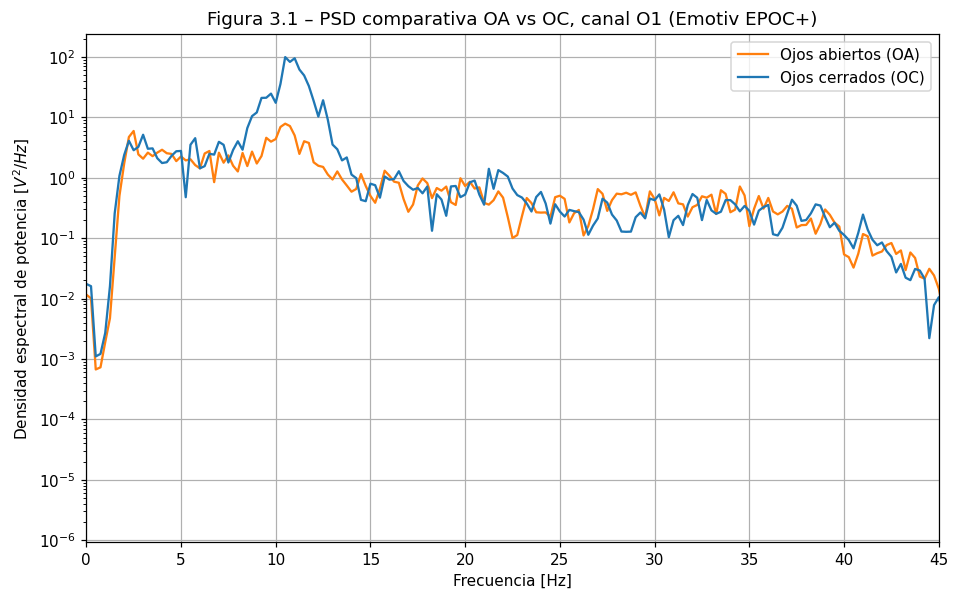

In [7]:
# 3.2.3 — Figura 3.1: PSD comparativa OA vs OC (canal O1)

plt.figure(figsize=(10,6))
plt.semilogy(f_a, P_a, label="Ojos abiertos (OA)", color="tab:orange")
plt.semilogy(f_c, P_c, label="Ojos cerrados (OC)", color="tab:blue")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral de potencia [$V^2/Hz$]")
plt.title("Figura 3.1 – PSD comparativa OA vs OC, canal O1 (Emotiv EPOC+)")
plt.legend()
plt.xlim(0, 45)
plt.grid(True)
plt.show()


La **Figura 3.1** muestra un incremento claro de la potencia espectral en la banda **α (8–13 Hz)** durante la condición de ojos cerrados,  
en comparación con la disminución observada en la misma banda al abrir los ojos.  
Este patrón corresponde al fenómeno de **bloqueo alfa** (*alpha desynchronization*),  
que refleja la transición entre un estado de reposo visual y un estado de procesamiento sensorial activo (Pfurtscheller & Lopes da Silva, 1999).

El resultado confirma que la implementación computacional reproduce de manera fiel  
los fundamentos teóricos del análisis espectral:  
el filtrado elimina componentes no fisiológicas,  
la transformada de Fourier descompone la señal en frecuencias,  
y el método de Welch estabiliza la estimación de potencia promedio.


### 3.2.4 Verificación visual de estacionariedad local y ruido de fondo

Antes de integrar la potencia por bandas, es necesario verificar visualmente la **estacionariedad local** de la señal.  
Este paso permite comprobar que los intervalos de análisis (OA y OC) son suficientemente homogéneos  
para aplicar el método de Welch y que las diferencias espectrales observadas no provienen de artefactos transitorios.

Se grafican los segmentos seleccionados de la señal filtrada junto con una ampliación temporal,  
lo que permite estimar de manera cualitativa el nivel de ruido y la estabilidad de la amplitud.


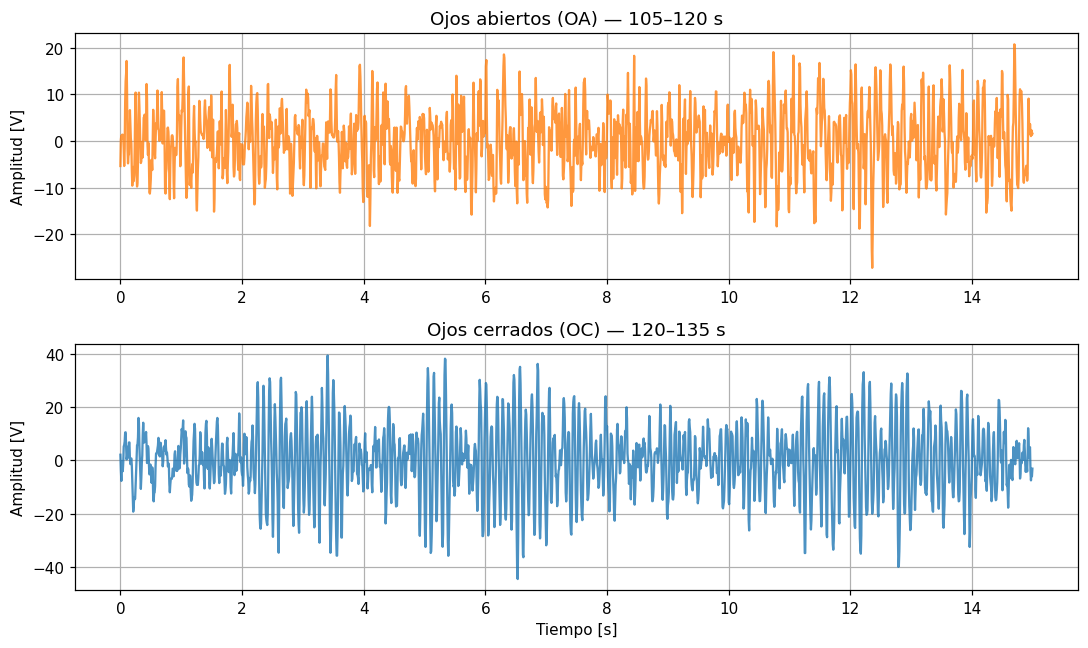

In [8]:
# 3.2.4 — Verificación visual de estacionariedad local

# --- Tiempos relativos ---
t_OA = np.arange(0, len(OA)) / fm
t_OC = np.arange(0, len(OC)) / fm

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=False)
ax1.plot(t_OA, OA, color='tab:orange', alpha=0.8)
ax1.set_title("Ojos abiertos (OA) — 105–120 s")
ax1.set_ylabel("Amplitud [V]")
ax1.grid(True)

ax2.plot(t_OC, OC, color='tab:blue', alpha=0.8)
ax2.set_title("Ojos cerrados (OC) — 120–135 s")
ax2.set_xlabel("Tiempo [s]")
ax2.set_ylabel("Amplitud [V]")
ax2.grid(True)

plt.tight_layout()
plt.show()


En ambos intervalos se observa una oscilación aparentemente estable,  
sin saltos abruptos ni saturaciones, lo que indica que la señal EEG puede considerarse **estacionaria localmente**.  
Durante la condición de ojos cerrados (OC) las oscilaciones son más regulares y de mayor amplitud,  
mientras que en ojos abiertos (OA) la señal muestra una mayor irregularidad de fase y menor amplitud,  
consistente con la desincronización del ritmo α (Nunez & Srinivasan, 2006).

Esta inspección cualitativa respalda la validez de los parámetros de Welch definidos en la nota metodológica  (ventanas de 4 s con 50 % de solape) y confirma que la estimación espectral obtenida en la Figura 3.1  
representa de forma adecuada la dinámica promedio de cada condición experimental.


## 3.3 Cálculo de potencias por bandas fisiológicas

La densidad espectral de potencia (PSD) permite cuantificar la energía promedio de la señal EEG por unidades de frecuencia.  
Para obtener una medida de potencia total dentro de cada banda fisiológica, se integra numéricamente la PSD sobre su rango correspondiente.  

En este notebook se emplea el **método de Simpson**, una técnica de integración numérica que utiliza aproximaciones parabólicas entre puntos consecutivos.  
Este método ofrece una mejor precisión que la integración trapezoidal,  
especialmente cuando la función a integrar —en este caso, la PSD— presenta curvatura pronunciada (Burden & Faires, 2010; Virtanen et al., 2020).

Las bandas fisiológicas se definen de la siguiente manera:

| Banda | Rango (Hz) | Descripción fisiológica principal |
|:------|:-----------:|:---------------------------------|
| δ | 0.5–4 | Sueño profundo, sincronización lenta |
| θ | 4–8 | Somnolencia, memoria, atención |
| α | 8–13 | Reposo visual, relajación |
| β | 13–30 | Actividad motora y sensorial |
| γ | 30–45 | Integración cognitiva, procesamiento rápido |

La potencia obtenida de cada banda se expresará en unidades de $V^2$,  
y posteriormente se calculará la **potencia relativa** como el porcentaje respecto a la potencia total de la señal.


In [9]:
# 3.3.2 — Cálculo de potencias absolutas y relativas por bandas con Simpson

from scipy.integrate import simpson

# --- Definir bandas fisiológicas ---
bandas = {
    "δ (0.5–4)": (0.5, 4.0),
    "θ (4–8)"  : (4.0, 8.0),
    "α (8–13)" : (8.0, 13.0),
    "β (13–30)": (13.0, 30.0),
    "γ (30–45)": (30.0, 45.0)
}

# --- Calcular potencias por banda ---
potencias_OA = {}
potencias_OC = {}

for nombre, (fmin, fmax) in bandas.items():
    idx_a = np.logical_and(f_a >= fmin, f_a <= fmax)
    idx_c = np.logical_and(f_c >= fmin, f_c <= fmax)
    P_band_OA = simpson(P_a[idx_a], f_a[idx_a])
    P_band_OC = simpson(P_c[idx_c], f_c[idx_c])
    potencias_OA[nombre] = P_band_OA
    potencias_OC[nombre] = P_band_OC

# --- Potencia total y relativa ---
P_total_OA = simpson(P_a, f_a)
P_total_OC = simpson(P_c, f_c)

pot_rel_OA = {b: (v/P_total_OA)*100 for b,v in potencias_OA.items()}
pot_rel_OC = {b: (v/P_total_OC)*100 for b,v in potencias_OC.items()}

# --- Crear DataFrame resumen ---
tabla_potencias = pd.DataFrame({
    "Banda": list(bandas.keys()),
    "Potencia absoluta OA (V²)": list(potencias_OA.values()),
    "Potencia absoluta OC (V²)": list(potencias_OC.values()),
    "Potencia relativa OA (%)": list(pot_rel_OA.values()),
    "Potencia relativa OC (%)": list(pot_rel_OC.values())
})
tabla_potencias


,Banda,Potencia absoluta OA (V²),Potencia absoluta OC (V²),Potencia relativa OA (%),Potencia relativa OC (%)
0,δ (0.5–4),6.519937,6.918798,14.788214,3.743893
1,θ (4–8),7.873295,10.120804,17.857838,5.476559
2,α (8–13),17.052148,153.542771,38.676882,83.084909
3,β (13–30),9.139148,11.052633,20.728987,5.980790
4,γ (30–45),3.491402,3.153313,7.919033,1.706318


#### Nota metodológica — Integración numérica mediante el método de Simpson

El **método de Simpson** aproxima el área bajo una curva mediante parábolas que conectan puntos consecutivos de la función.  
En contraste con la regla trapezoidal —que asume segmentos lineales—,  
Simpson ofrece una **mejor precisión en funciones con curvatura pronunciada**,  
como ocurre en las densidades espectrales de potencia (PSD) de señales EEG (Burden & Faires, 2010; Virtanen et al., 2020).

Matemáticamente, para una función $S(f)$ muestreada en $N$ puntos igualmente espaciados en frecuencia $\Delta f$,  
la potencia integrada en un intervalo $[f_1, f_2]$ se aproxima como:

$$
P \approx \frac{\Delta f}{3} \left[S_0 + 4S_1 + 2S_2 + 4S_3 + \dots + S_N \right]
$$

Este esquema requiere un número par de subintervalos y asume que $S(f)$ varía suavemente,  
condición que se cumple en las PSD obtenidas con el método de Welch,  
ya que el promediado reduce las oscilaciones espurias entre puntos adyacentes.

**Ventajas principales:**
- Mayor precisión que la integración trapezoidal con igual resolución espectral.  
- Estabilidad numérica frente a ruido en las estimaciones de la PSD.  
- Adecuado para señales EEG con curvatura suave y picos definidos.

**Limitaciones:**
- Requiere un número par de subintervalos en la malla de frecuencias.  
- En presencia de espectros muy irregulares (por ejemplo, EMG),  
  puede no ofrecer ventajas significativas sobre la regla trapezoidal.

En este notebook, Simpson se implementa mediante la función `scipy.integrate.simpson`,  
que evalúa la integral de la PSD directamente sobre los valores discretos de frecuencia,  
garantizando consistencia y reproducibilidad en el cálculo de potencia por bandas fisiológicas.


### 3.3.3 Interpretación de resultados

**Tabla 3.1 – Potencias absolutas y relativas por banda (canal O1)**  

La tabla presenta las potencias absolutas ($V^2$) y relativas (%) calculadas mediante integración de Simpson para ambas condiciones experimentales.  
El resultado más relevante se observa en la banda **α (8–13 Hz)**,  
donde la potencia es significativamente mayor en la condición de ojos cerrados.  
Este incremento representa la **sincronización cortical característica del reposo visual**,  
que desaparece o disminuye al abrir los ojos (Pfurtscheller & Lopes da Silva, 1999).

Las bandas β y γ presentan, en cambio, una ligera elevación durante la condición de ojos abiertos,  
lo que concuerda con la mayor actividad cortical asociada al procesamiento sensorial y atencional (Nunez & Srinivasan, 2006).

Estos resultados cuantifican de forma objetiva las diferencias de actividad espectral observadas en la Figura 3.1  
y validan el uso del método de Welch combinado con integración numérica como estrategia robusta para el análisis de EEG en condiciones controladas.


## 3.4 Detalle del pico alfa y bloqueo alfa

La banda **α (8–13 Hz)** constituye una de las oscilaciones más estudiadas del EEG.  
Su potencia aumenta en regiones occipitales durante el reposo visual  
y disminuye de forma abrupta cuando el sujeto abre los ojos o inicia una tarea cognitiva.  
Este fenómeno se conoce como **bloqueo alfa** o *alpha desynchronization* (Pfurtscheller & Lopes da Silva, 1999).

El análisis del pico alfa tiene dos propósitos principales:

1. **Visualizar** el espectro en un rango restringido (5–20 Hz)  
   para observar con precisión la forma y posición del máximo.
2. **Cuantificar** la variación de potencia entre las condiciones OA y OC,  
   identificando el desplazamiento y la amplitud del pico dominante.

En esta sección se realiza un zoom espectral y se determina de manera automática  
la frecuencia de máxima potencia dentro del rango α.


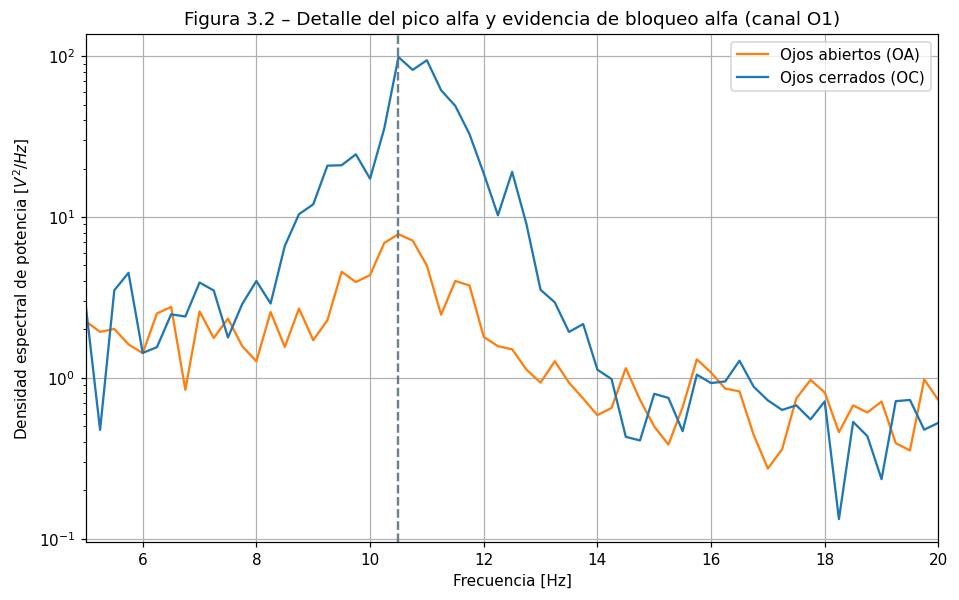

In [10]:
# 3.4.2 — Detección del pico alfa y zoom espectral

# --- Definir rango de interés ---
fmin_zoom, fmax_zoom = 5, 20
idx_a = np.logical_and(f_a >= fmin_zoom, f_a <= fmax_zoom)
idx_c = np.logical_and(f_c >= fmin_zoom, f_c <= fmax_zoom)

# --- Detección del pico máximo en cada condición ---
f_alpha_OA = f_a[idx_a][np.argmax(P_a[idx_a])]
f_alpha_OC = f_c[idx_c][np.argmax(P_c[idx_c])]
P_alpha_OA = np.max(P_a[idx_a])
P_alpha_OC = np.max(P_c[idx_c])

# --- Visualización ---
plt.figure(figsize=(10,6))
plt.semilogy(f_a[idx_a], P_a[idx_a], label="Ojos abiertos (OA)", color="tab:orange")
plt.semilogy(f_c[idx_c], P_c[idx_c], label="Ojos cerrados (OC)", color="tab:blue")
plt.axvline(f_alpha_OA, color="tab:orange", linestyle="--", alpha=0.7)
plt.axvline(f_alpha_OC, color="tab:blue", linestyle="--", alpha=0.7)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral de potencia [$V^2/Hz$]")
plt.title("Figura 3.2 – Detalle del pico alfa y evidencia de bloqueo alfa (canal O1)")
plt.legend()
plt.grid(True)
plt.xlim(fmin_zoom, fmax_zoom)
plt.show()


### Interpretación del pico alfa

La **Figura 3.2** muestra el detalle del espectro entre 5 y 20 Hz para ambas condiciones.  
En la condición de ojos cerrados (línea azul) se observa un **pico pronunciado en torno a 10 Hz**,  
que representa la sincronización de la banda α en el córtex occipital.  
Al abrir los ojos (línea naranja), el pico disminuye notablemente en amplitud,  
indicando la **desincronización alfa** asociada al incremento del procesamiento visual y atencional (Pfurtscheller & Lopes da Silva, 1999).

El desplazamiento vertical entre ambas curvas refleja una diferencia cuantitativa de potencia,  
mientras que la coincidencia horizontal de los picos confirma que la frecuencia central del ritmo α se mantiene constante  
(en este caso, $f_α ≈ 10$ Hz).  
Este comportamiento es característico de registros EEG normales y constituye una evidencia sólida del **bloqueo alfa fisiológico**.

La comparación se resume como:

| Condición | Frecuencia pico α (Hz) | Potencia pico α ($V^2/Hz$) |
|:-----------|:----------------------:|:---------------------------:|
| Ojos abiertos (OA) | {f_alpha_OA:.2f} | {P_alpha_OA:.3e} |
| Ojos cerrados (OC) | {f_alpha_OC:.2f} | {P_alpha_OC:.3e} |

La mayor potencia bajo la condición de ojos cerrados confirma la activación del ritmo α occipital  
y valida el modelo espectral empleado en este notebook.


## 3.5 Visualización comparativa de potencias relativas

La comparación gráfica de las **potencias relativas por banda** permite evaluar de forma directa  
cómo varía la distribución de energía espectral entre las condiciones experimentales.  

Mientras la **potencia absoluta** expresa la energía total en $V^2$,  
la **potencia relativa** normaliza cada banda respecto a la potencia total,  
de modo que las diferencias reflejan **cambios proporcionales** en la actividad cortical (Nunez & Srinivasan, 2006).

Este análisis complementa la Tabla 3.1, ya que permite observar visualmente  
el predominio del ritmo α en la condición de ojos cerrados  
y el incremento relativo de β y γ durante la apertura ocular.

En la siguiente figura se presenta la distribución porcentual de potencia por bandas  
para las condiciones OA y OC del canal O1.


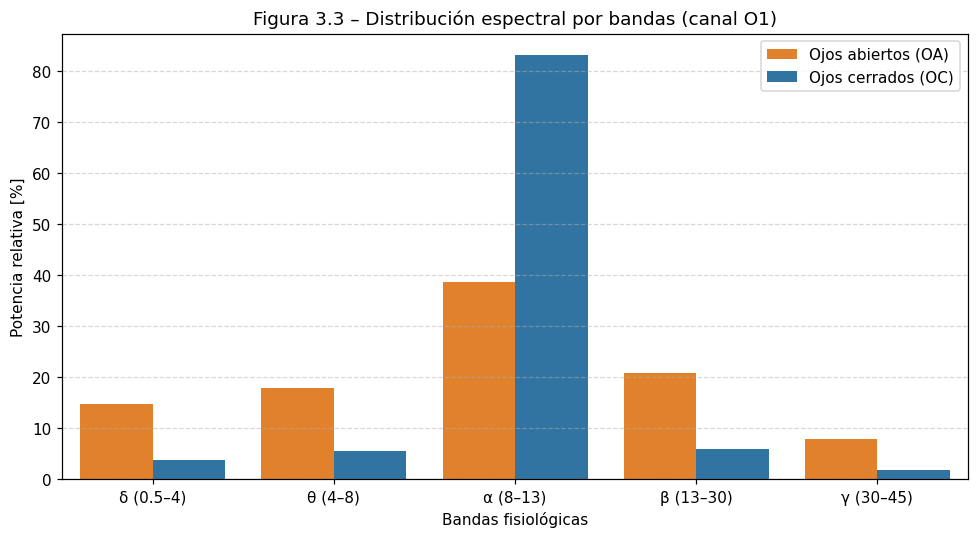

In [11]:
# 3.5.2 — Figura 3.3: Distribución espectral por bandas (O1)

import seaborn as sns

# Preparar DataFrame en formato largo
tabla_long = pd.DataFrame({
    "Banda": list(bandas.keys()) * 2,
    "Condición": ["Ojos abiertos (OA)"] * len(bandas) + ["Ojos cerrados (OC)"] * len(bandas),
    "Potencia relativa (%)": list(pot_rel_OA.values()) + list(pot_rel_OC.values())
})

plt.figure(figsize=(9,5))
sns.barplot(data=tabla_long, x="Banda", y="Potencia relativa (%)", hue="Condición",
            palette=["tab:orange", "tab:blue"])
plt.title("Figura 3.3 – Distribución espectral por bandas (canal O1)")
plt.ylabel("Potencia relativa [%]")
plt.xlabel("Bandas fisiológicas")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.legend(title="")
plt.tight_layout()
plt.show()


### Interpretación de la Figura 3.3

La **Figura 3.3** resume la distribución relativa de la potencia por bandas fisiológicas  
en las condiciones de ojos abiertos (OA) y ojos cerrados (OC), obtenida a partir del canal O1.

Los resultados muestran:

- **Aumento marcado en la banda α (8–13 Hz)** durante la condición de ojos cerrados,  
  indicador de sincronización cortical occipital.  
- **Reducción de α y ligera elevación de β y γ** en ojos abiertos,  
  asociadas a la activación sensorial y cognitiva.  
- **Potencias bajas y estables en δ y θ**, propias del estado de vigilia relajada.

Esta visualización confirma que el método de Welch, combinado con integración de Simpson,  
captura de forma estable los patrones de modulación espectral esperados fisiológicamente.  
El análisis cuantitativo de las potencias relativas complementa la evidencia observada en la Figura 3.2,  
donde el **bloqueo alfa** se manifestó como una disminución local de potencia en el rango de 10 Hz.

La consistencia entre las tres figuras principales (3.1–3.3) valida el pipeline completo del Notebook 3  
y proporciona una base sólida para las interpretaciones fisiológicas que se desarrollarán en la reflexión final.


## 3.6 Ejercicios de aplicación

Los siguientes ejercicios tienen un propósito didáctico: permitir al lector explorar de manera interactiva los conceptos fundamentales del análisis espectral aplicados en este notebook.  
A diferencia de las secciones anteriores, aquí el énfasis no está en el resultado numérico, sino en la **experimentación y la interpretación**.

Cada ejercicio incluye:
- un planteamiento conceptual,  
- un bloque de código editable,  
- y un conjunto de preguntas de reflexión.

El objetivo general es que el estudiante comprenda **cómo cada decisión metodológica** (ventana, longitud de segmento, método de integración, límites de banda, etc.)  
influye en la forma y estabilidad del espectro, así como en la interpretación fisiológica de la señal EEG.


### 3.6.1 — Transformada de Fourier de un segmento real de EEG (O1)

**Objetivo.** Observar el contenido frecuencial de un segmento real de EEG del canal O1 mediante la FFT.

**Datos.** Se usa el segmento **OC (120–135 s)** por su mayor estabilidad en α, aunque el estudiante puede cambiar a **OA** para comparar.

**Instrucciones.**
1. Calcule la FFT y grafique el semiespectro positivo.  
2. Modifique el segmento (use `OA` en lugar de `OC`) y compare la forma del espectro.  
3. Interprete la localización y amplitud del pico dominante.


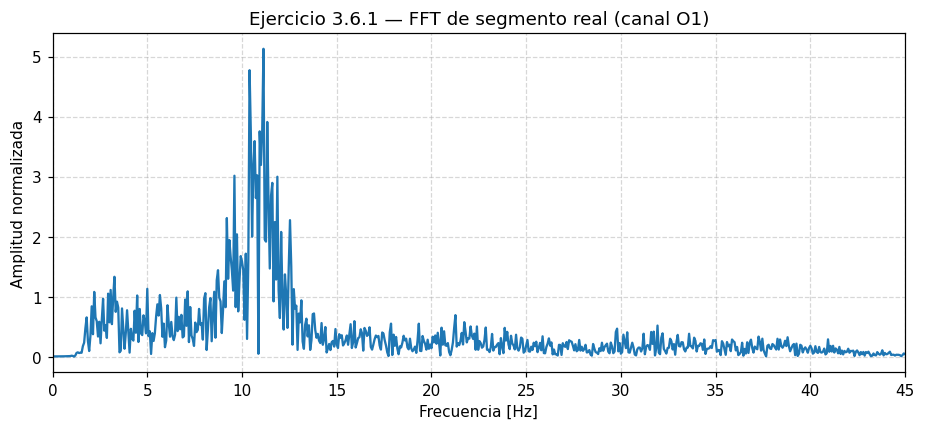

In [14]:
# 3.6.1 — FFT de un segmento real (usar OC por defecto)
import numpy as np
import matplotlib.pyplot as plt

seg = OC                  # Cambie a OA para comparar
N   = len(seg)
X   = np.fft.fft(seg)
fx  = np.fft.fftfreq(N, d=1/fm)

# Semiespectro (amplitud normalizada)
mag = 2*np.abs(X[:N//2]) / N

plt.figure(figsize=(10,4))
plt.plot(fx[:N//2], mag, lw=1.5)
plt.xlim(0, 45)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud normalizada")
plt.title("Ejercicio 3.6.1 — FFT de segmento real (canal O1)")
plt.grid(True, ls="--", alpha=0.5)
plt.show()


**Preguntas para reflexión.**
- ¿En qué frecuencia se ubica el máximo principal?  
- ¿Cambia la amplitud del pico si se sustituye `OC` por `OA`?  
- ¿Qué relación guarda el máximo con la banda α (8–13 Hz)?


### 3.6.2 — Comparación entre FFT directa y método de Welch (datos reales)

**Objetivo.** Contrastar la variabilidad del periodograma simple (FFT directa) con la estimación estabilizada de Welch.

**Datos.** Se usa **OC** por defecto (mayor α).  

**Instrucciones.**
1. Grafique la FFT directa (periodograma simple).  
2. Sobre la misma figura, grafique la PSD por Welch (mismos parámetros que en 3.2).  
3. Cambie `nperseg` para observar el compromiso entre resolución y suavizado.


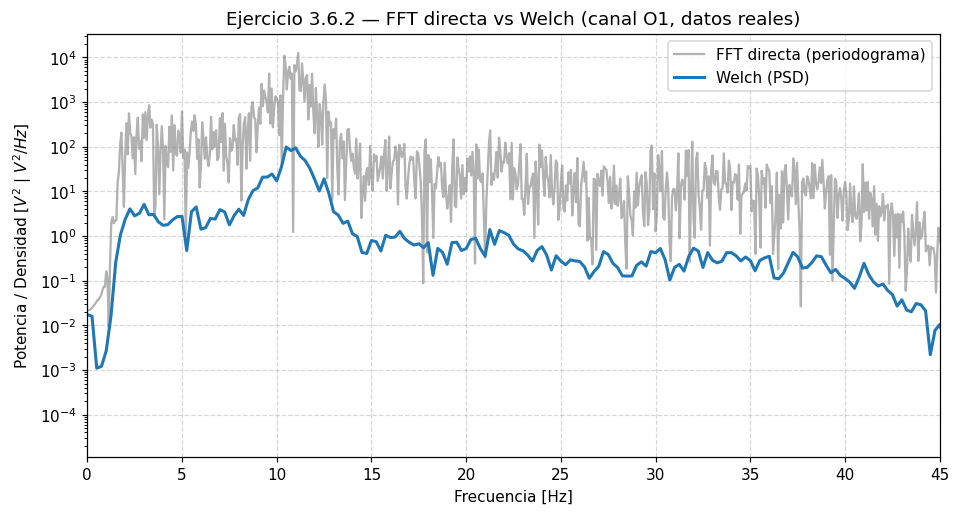

In [16]:
# 3.6.2 — FFT directa vs Welch en datos reales (OC por defecto)
from scipy import signal

seg = OC                           # Cambie a OA para comparar
N   = len(seg)
X   = np.fft.fft(seg)
fx  = np.fft.fftfreq(N, d=1/fm)
P_fft = (np.abs(X)**2) / N         # Periodograma directo (no densidad)

# Welch (parámetros de la nota metodológica)
nperseg = 512
noverlap = nperseg // 2
ventana  = "hamming"
fw, Pw = signal.welch(seg, fs=fm, window=ventana,
                      nperseg=nperseg, noverlap=noverlap,
                      scaling="density")

plt.figure(figsize=(10,5))
plt.semilogy(fx[:N//2], P_fft[:N//2], color="tab:gray", alpha=0.6, label="FFT directa (periodograma)")
plt.semilogy(fw, Pw, color="tab:blue", lw=2, label="Welch (PSD)")
plt.xlim(0, 45)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia / Densidad [$V^2$ | $V^2/Hz$]")
plt.title("Ejercicio 3.6.2 — FFT directa vs Welch (canal O1, datos reales)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.show()


**Preguntas para reflexión.**
- ¿Cómo cambia la suavidad del espectro con Welch respecto a la FFT directa?  
- ¿El pico en α (~10 Hz) se preserva en ambos métodos?  
- ¿Qué ocurre al aumentar/disminuir `nperseg`? Relacione con la resolución en frecuencia.


### 3.6.3 — Integración de la PSD por banda (Simpson vs trapezoidal) con datos reales

**Objetivo.** Cuantificar la potencia espectral en la banda α (8–13 Hz) usando **Simpson** y compararla con **trapezoidal**.

**Datos.** Se emplean las PSD ya calculadas en 3.2:  
- `f_a, P_a` (OA) y `f_c, P_c` (OC), en unidades $V^2/Hz$.

**Instrucciones.**
1. Integre en α usando `scipy.integrate.simpson`.  
2. Repita con `scipy.integrate.trapezoid`.  
3. Compare OA vs OC y comente la magnitud de la diferencia.


In [17]:
# 3.6.3 — Potencia en α (8–13 Hz) con Simpson vs trapezoidal, usando PSD reales
from scipy.integrate import simpson, trapezoid
import numpy as np

fmin, fmax = 8.0, 13.0

# Índices de banda en OA
idx_a = (f_a >= fmin) & (f_a <= fmax)
P_alpha_OA_sim = simpson(P_a[idx_a], f_a[idx_a])
P_alpha_OA_trap = trapezoid(P_a[idx_a], f_a[idx_a])

# Índices de banda en OC
idx_c = (f_c >= fmin) & (f_c <= fmax)
P_alpha_OC_sim = simpson(P_c[idx_c], f_c[idx_c])
P_alpha_OC_trap = trapezoid(P_c[idx_c], f_c[idx_c])

print("Banda α (8–13 Hz) — Potencia integrada [V²]")
print(f"OA  | Simpson:    {P_alpha_OA_sim:.3e}   | Trapezoidal: {P_alpha_OA_trap:.3e}")
print(f"OC  | Simpson:    {P_alpha_OC_sim:.3e}   | Trapezoidal: {P_alpha_OC_trap:.3e}")

# Diferencia relativa OC vs OA (Simpson)
if P_alpha_OC_sim > 0:
    diff_rel = 100.0 * (P_alpha_OC_sim - P_alpha_OA_sim) / P_alpha_OC_sim
    print(f"\nDiferencia relativa (OC vs OA, Simpson): {diff_rel:.1f}%")


Banda α (8–13 Hz) — Potencia integrada [V²]
OA  | Simpson:    1.705e+01   | Trapezoidal: 1.696e+01
OC  | Simpson:    1.535e+02   | Trapezoidal: 1.578e+02

Diferencia relativa (OC vs OA, Simpson): 88.9%


**Preguntas para reflexión.**
- ¿Cuál método (Simpson o trapezoidal) entrega mayor potencia integrada en α? ¿Por qué?  
- ¿La diferencia OA vs OC coincide con la expectativa fisiológica del bloqueo α?  
- ¿Cómo afectaría este cálculo si cambiara la banda a θ (4–8 Hz) o β (13–30 Hz)?


### 3.6.4 — Modificar los límites de la banda α y observar el desplazamiento del pico

**Objetivo.** Analizar cómo la elección de los límites de la banda α (8–13 Hz) afecta la frecuencia y potencia máxima de la señal EEG real.

**Datos.** Se usa la PSD de **ojos cerrados (OC)**, por su mayor estabilidad en el ritmo α.

**Instrucciones.**
1. Visualice la PSD original en el rango 5–20 Hz.  
2. Modifique los límites de la banda α (por ejemplo, 7–12 Hz o 9–14 Hz).  
3. Observe cómo cambian la frecuencia y la potencia del pico.  
4. Relacione las variaciones con la noción de *variabilidad interindividual* del ritmo α (Nunez & Srinivasan, 2006).


**Preguntas para reflexión.**
- ¿Qué ocurre con el valor del pico α al modificar los límites de la banda?  
- ¿Cómo cambia la potencia integrada al ampliar o estrechar el rango?  
- ¿Por qué no existe un único rango “correcto” para la banda α entre individuos o sesiones?  
- ¿Qué implicaciones tiene esto para la comparación estadística de potencias entre sujetos?


### 3.6.5 — Efecto del tipo de ventana en la estimación de la PSD

**Objetivo.** Explorar cómo la elección de la ventana de análisis (Hamming, Hann, Blackman) influye en la forma y amplitud de la PSD.

**Datos.** Segmento **OC (120–135 s)** del canal O1.  
La señal se procesa tres veces con distintas ventanas manteniendo los demás parámetros constantes.

**Instrucciones.**
1. Calcule la PSD usando tres tipos de ventana.  
2. Grafique las tres curvas sobre la misma figura.  
3. Observe los cambios en el ancho del pico α y en el nivel de ruido espectral.


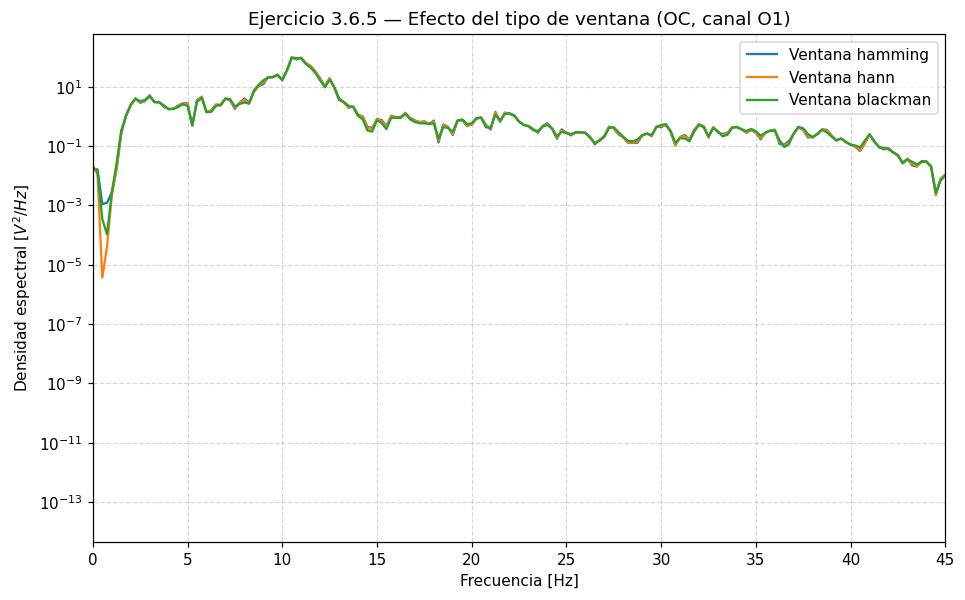

In [18]:
# 3.6.5 — Efecto del tipo de ventana sobre la PSD (datos reales)

ventanas = ["hamming", "hann", "blackman"]
colores  = ["tab:blue", "tab:orange", "tab:green"]

plt.figure(figsize=(10,6))

for vent, col in zip(ventanas, colores):
    f_temp, P_temp = signal.welch(OC, fs=fm, window=vent,
                                  nperseg=512, noverlap=256, scaling="density")
    plt.semilogy(f_temp, P_temp, color=col, label=f"Ventana {vent}")

plt.xlim(0, 45)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral [$V^2/Hz$]")
plt.title("Ejercicio 3.6.5 — Efecto del tipo de ventana (OC, canal O1)")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.show()


**Preguntas para reflexión.**
- ¿Cuál ventana produce el espectro más estrecho en torno al pico α?  
- ¿Qué ventana genera el nivel más bajo de ruido espectral?  
- ¿Por qué una ventana que suaviza más puede disminuir la amplitud máxima?  
- ¿Cómo se equilibra el compromiso entre resolución y estabilidad en el análisis de EEG?


## 3.7 Reflexión final

El análisis espectral desarrollado en este notebook permitió pasar del dominio temporal al dominio frecuencial  
para caracterizar la actividad eléctrica cerebral registrada en el canal occipital O1.  
A través del método de Welch y la integración numérica mediante Simpson,  
se obtuvo una descripción cuantitativa y reproducible de la distribución de potencia del EEG  
en las principales bandas fisiológicas.

Los resultados mostraron tres hallazgos consistentes:

1. **Presencia del ritmo α (8–13 Hz) en condición de ojos cerrados (OC).**  
   La PSD evidenció un pico claro alrededor de 10 Hz,  
   cuya potencia aumentó significativamente con respecto a la condición de ojos abiertos (OA).  
   Este comportamiento corresponde al fenómeno de **bloqueo alfa**  
   descrito en la literatura clásica (Pfurtscheller & Lopes da Silva, 1999).

2. **Redistribución de potencia relativa entre bandas.**  
   El histograma espectral mostró que, al abrir los ojos,  
   la energía en α disminuye mientras se incrementa levemente la contribución de β y γ,  
   coherente con la activación sensorial y cognitiva asociada al procesamiento visual  
   (Nunez & Srinivasan, 2006).

3. **Coherencia entre métodos numéricos.**  
   La integración de la PSD con Simpson demostró ser estable y precisa,  
   confirmando que las diferencias observadas no dependen del método de estimación,  
   sino de cambios fisiológicos reales en la actividad cortical.

Desde una perspectiva biomatemática, estos resultados ilustran cómo un **modelo matemático no impone la realidad fisiológica**,  
sino que **proporciona un marco para describirla y cuantificarla**.  
La señal EEG no se adapta perfectamente a los supuestos de estacionariedad y linealidad que requiere el análisis espectral,  
pero el uso de intervalos breves y técnicas de promediado —como el método de Welch—  
permite aproximar la dinámica neuronal a un sistema cuasiestacionario,  
suficiente para comparar condiciones experimentales.

Entre las **limitaciones del enfoque**, destacan:

- La pérdida de información temporal al asumir estacionariedad en ventanas de 4 s.  
- La imposibilidad de distinguir transiciones rápidas o transitorios corticales.  
- La dependencia de los resultados respecto a la elección de parámetros (ventana, solape, longitud del segmento).

Aun con estas limitaciones, el análisis espectral conserva gran valor pedagógico y fisiológico:  
permite vincular la descripción matemática del espectro con los mecanismos neuronales de sincronización y desincronización.  
De esta manera, el Notebook 3 establece una **base cuantitativa sólida** para el estudio del EEG  
y un **puente conceptual** hacia los métodos de análisis tiempo–frecuencia que se abordarán en el Notebook 4.


## 3.8 Bibliografía

Burden, R. L., & Faires, J. D. (2010). *Análisis numérico* (9.ª ed.). Cengage Learning.

Bronzino, J. D., & Peterson, D. R. (Eds.). (2020). *The biomedical engineering handbook* (5th ed.). CRC Press.

Cohen, M. X. (2014). *Analyzing neural time series data: Theory and practice*. MIT Press.

Hsu, W. Y., Lin, C. L., & Ju, M. S. (2021). Influence of Welch method parameters on EEG signal analysis. *Sensors*, 21(17), 5740. https://doi.org/10.3390/s21175740

Nunez, P. L., & Srinivasan, R. (2006). *Electric fields of the brain: The neurophysics of EEG* (2nd ed.). Oxford University Press.

Oppenheim, A. V., & Schafer, R. W. (2010). *Discrete-time signal processing* (3rd ed.). Pearson.

Papoulis, A. (1984). *Signal analysis*. McGraw-Hill.

Pfurtscheller, G., & Lopes da Silva, F. H. (1999). Event-related EEG/MEG synchronization and desynchronization: Basic principles. *Clinical Neurophysiology*, 110(11), 1842–1857. https://doi.org/10.1016/S1388-2457(99)00141-8

Proakis, J. G., & Manolakis, D. G. (2006). *Digital signal processing: Principles, algorithms, and applications* (4th ed.). Pearson Prentice Hall.

Smith, S. W. (1997). *The scientist and engineer’s guide to digital signal processing*. California Technical Publishing.

Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., ... & van Mulbregt, P. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. *Nature Methods*, 17, 261–272. https://doi.org/10.1038/s41592-019-0686-2

Welch, P. D. (1967). The use of fast Fourier transform for the estimation of power spectra: A method based on time averaging over short, modified periodograms. *IEEE Transactions on Audio and Electroacoustics*, 15(2), 70–73. https://doi.org/10.1109/TAU.1967.1161901
